In [1]:
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs

import xarray as xr
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from pathlib import Path
import netCDF4 as nc

# for plot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import dask

/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [337]:
# shift by cartopy: https://stackoverflow.com/questions/59584276/cartopy-set-extent-with-central-longitude-180
def contf_tmean(title, data, label, colormap, extend, varmin, varmax, space, lat_min, lat_max, lon_min, lon_max):
    #proj = ccrs.PlateCarree(central_longitude=180) # Create Mollweide projections
    proj = ccrs.PlateCarree(central_longitude=0)
    fig = plt.figure(figsize=(18, 12))
    ax = fig.add_subplot(111, projection=proj)
    #minlon = lon_min + 5 + 180
    #maxlon = lon_max - 5 + 180
    minlon = lon_min + 5 
    maxlon = lon_max - 5 
    ax.set_extent([minlon,maxlon,lat_min+5,lat_max-5],ccrs.PlateCarree())
    #plot = data.where((data.lat >= lat_min) & (data.lat <= lat_max) & (data.lon >= lon_min) & (data.lon <= lon_max)).plot(
    plot = data.plot(
                      ax=ax,
                      transform=ccrs.PlateCarree(),
                      cmap=colormap,
                      vmin=varmin,
                      vmax=varmax,
                     # cbar_kwargs={'label': 'Surface Temperature [K]',
                     #              'extend': 'both',
                     #              'shrink': .5,
                     #              'orientation': 'horizontal'},
                      add_colorbar=False
                     )
    bounds = np.linspace(varmin,varmax, space)
    cb = plt.colorbar(plot, orientation="horizontal", fraction=0.05, pad=0.10, extend=extend,ticks=bounds, boundaries=bounds)
    cb.set_label(label=label, size=15, weight='bold')
    cb.ax.tick_params(labelsize=20)
    cb.ax.set_xticklabels(bounds,rotation=270)
    ax.coastlines(resolution='10m', lw=0.51)
    gl=ax.gridlines(draw_labels=True, crs=proj)
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 15}, {'fontsize': 15}
    ax.yaxis.tick_right() 
    ax.set_title(title, y=1.1, fontsize=25)
    _ = fig.subplots_adjust(left=0.01, right=0.98, hspace=0, wspace=0, top=0.9, bottom=0.25)

In [24]:
def colormap_create(cmap, cnumber, loc_boundary_low, loc_boundary_high):
    get_cmap = cm.get_cmap(cmap,cnumber) 
    cmap_edit = get_cmap(np.linspace(0,1,cnumber))
    white = np.array([255/256, 255/256, 255/256, 1])
    cmap_edit[loc_boundary_low:loc_boundary_high] = white
    cmap_new = matplotlib.colors.ListedColormap(cmap_edit)
    return cmap_new

In [330]:
Cmap_temp_new = colormap_create('RdYlBu_r',31,0,1)
Cmap_rain_new = colormap_create('YlGnBu',18,0,1)
Cmap_et_new = colormap_create('YlGnBu_r',11,0,1)
BrBG_new = colormap_create('BrBG',11,5,6)
et_diff_new = colormap_create('BrBG_r',11,5,6)

In [231]:
Cmap_pres_new = colormap_create('viridis',31,0,1)
Cmap_veg_new = colormap_create('viridis_r',11,0,1)

pres_diff_new = colormap_create('PiYG_r',11,5,6)
temp_diff_new = colormap_create('RdYlBu_r',11,5,6)

# Load ENS experiments

In [357]:
file_ens = Path('/work/mh1049/k206184/icon-easyms/experiments/ENS_climatology/remap')
glob_pattern = 'ensem_atm_2d_ml_clim_remap'
#glob_pattern = 'ensem_lnd_basic_ml_clim_remap_'

file_ens = sorted([str(f) for f in file_ens.glob(f'{glob_pattern}*.nc')])[:] # time still error... why?

dset_ens = xr.open_mfdataset(file_ens,parallel=True,use_cftime=True)['ts'].chunk({'time':24})
dset_ens

<xarray.DataArray 'ts' (time: 132, lat: 180, lon: 360)>
dask.array<rechunk-merge, shape=(132, 180, 360), dtype=float32, chunksize=(24, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2249-01-31 23:45:00 ... 2349-12-31 23:45:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    standard_name:  surface_temperature
    long_name:      surface temperature
    units:          K
    param:          0.0.0

In [358]:
file_ctl = Path('/work/mh1049/k206184/icon-easyms/experiments/CTL_climatology/remap')
glob_pattern = 'sus2200_clim_atm_2d_ml_remap_'
#glob_pattern = 'sus2200_clim_lnd_basic_ml_remap_'

file_ctl = sorted([str(f) for f in file_ctl.glob(f'{glob_pattern}*.nc')])[:] # time still error... why?

dset_ctl = xr.open_mfdataset(file_ctl,parallel=True,use_cftime=True)['ts'].chunk({'time':24})
dset_ctl

<xarray.DataArray 'ts' (time: 132, lat: 180, lon: 360)>
dask.array<rechunk-merge, shape=(132, 180, 360), dtype=float32, chunksize=(24, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2249-01-31 23:45:00 ... 2349-12-31 23:45:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    standard_name:  surface_temperature
    long_name:      surface temperature
    units:          K
    param:          0.0.0

In [359]:
dset_ens.coords['lon'] = (dset_ens.coords['lon'] + 180) % 360 - 180
dset_ens = dset_ens.sortby(dset_ens.lon)

In [360]:
dset_ctl.coords['lon'] = (dset_ctl.coords['lon'] + 180) % 360 - 180
dset_ctl = dset_ctl.sortby(dset_ctl.lon)

# Make yearly mean

In [224]:
dset_ens

<xarray.DataArray 'pplcc_tree_fract_box' (time: 132, lat: 180, lon: 360)>
dask.array<getitem, shape=(132, 180, 360), dtype=float32, chunksize=(24, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2249-01-31 23:45:00 ... 2349-12-31 23:45:00
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    standard_name:  tree_fract
    long_name:      Tree fraction relative to the grid cell area
    units:          1
    code:           255

In [99]:
dset_ens_season = dset_ens.groupby("time.month").mean("time")
dset_ctl_season = dset_ctl.groupby("time.month").mean("time")

# Time average

In [294]:
# precipitation / ET
ens_timavg=dset_ens.mean("time")*3600*24
ctl_timavg=dset_ctl.mean("time")*3600*24

In [363]:
# Pressure / ocean-heatflux / vegetation [kg/m^2/s * 10**12 ->ng/m^2/s]
ens_timavg=dset_ens.mean("time") #*10**6
ctl_timavg=dset_ctl.mean("time") #*10**6

In [364]:
ens_timavg.values

array([[240.13527, 245.96712, 245.96712, ..., 240.13527, 240.13527,
        240.13527],
       [240.13527, 245.96712, 245.96712, ..., 240.13527, 240.13527,
        240.13527],
       [240.13527, 245.96712, 245.96712, ..., 240.13527, 240.13527,
        240.13527],
       ...,
       [275.5901 , 275.5901 , 274.6709 , ..., 275.5901 , 275.5901 ,
        275.5901 ],
       [275.5901 , 275.5901 , 274.6709 , ..., 275.5901 , 275.5901 ,
        275.5901 ],
       [275.5901 , 275.5901 , 274.6709 , ..., 275.5901 , 275.5901 ,
        275.5901 ]], dtype=float32)

## Zonally mean

In [56]:
TRP_ens_zonal=dset_ens.mean(("lon"))
AMZ_ens_zonal=dset_ens.sel(lon=slice(-65,-55)).mean(("lon"))
AFC_ens_zonal=dset_ens.sel(lon=slice(-10,50)).mean(("lon"))

In [47]:
TRP_ens_zonal=dset_ens_season.mean(("lon"))
AMZ_ens_zonal=dset_ens_season.sel(lon=slice(-65,-55)).mean(("lon"))
AFC_ens_zonal=dset_ens_season.sel(lon=slice(-10,50)).mean(("lon"))

In [57]:
TRP_ctl_zonal=dset_ctl.mean(("lon"))
AMZ_ctl_zonal=dset_ctl.sel(lon=slice(-65,-55)).mean(("lon"))
AFC_ctl_zonal=dset_ctl.sel(lon=slice(-10,50)).mean(("lon"))

In [48]:
TRP_ctl_zonal=dset_ctl_season.mean(("lon"))
AMZ_ctl_zonal=dset_ctl_season.sel(lon=slice(-65,-55)).mean(("lon"))
AFC_ctl_zonal=dset_ctl_season.sel(lon=slice(-10,50)).mean(("lon"))

In [365]:
# pressure zonally mean [height, lat]
ens_pres_zonal=ens_timavg.mean(("lon"))
ctl_pres_zonal=ctl_timavg.mean(("lon"))

In [135]:
ens_pres_merid=ens_timavg.mean(("lat"))
ctl_pres_merid=ctl_timavg.mean(("lat"))

# ZONAL-TIME Average

In [63]:
TRP_ctl_zonal_mon=TRP_ctl_zonal.mean("time")
AMZ_ctl_zonal_mon=AMZ_ctl_zonal.mean("time")
AFC_ctl_zonal_mon=AFC_ctl_zonal.mean("time")

In [62]:
TRP_ens_zonal_mon=TRP_ens_zonal.mean("time")
AMZ_ens_zonal_mon=AMZ_ens_zonal.mean("time")
AFC_ens_zonal_mon=AFC_ens_zonal.mean("time")

# Zonal mean over Tropical / Amazon / Africa

In [15]:
from datetime import datetime, timedelta

lat_idx = np.arange(-90,90.1,10)
#time_idx = np.arange(datetime(2240, 1,1), datetime(2340, 1, 1), timedelta(days=30)).astype(datetime)
time_idx = np.arange(datetime(2240, 1,1), datetime(2350, 1, 1), np.timedelta64(10, 'Y'),  
         dtype='datetime64[Y]').astype('datetime64[D]')
#date_idx = [x.datetime().isoformat() for x in time_idx]
#dt_idx = np.array(date_idx)
print(np.shape(time_idx))

# 100 years * 12 months

(11,)


In [49]:
# over the both land and ocean
TRP_ens_zonal_data = TRP_ens_zonal.values.T
TRP_ens_zonal_data = TRP_ens_zonal_data*3600*24

AMZ_ens_zonal_data = AMZ_ens_zonal.values.T
print(np.shape(AMZ_ens_zonal_data)) # y, x
AMZ_ens_zonal_data = AMZ_ens_zonal_data*3600*24

AFC_ens_zonal_data = AFC_ens_zonal.values.T
print(np.shape(AFC_ens_zonal_data)) # y, x
AFC_ens_zonal_data = AFC_ens_zonal_data*3600*24

(180, 12)
(180, 12)


In [50]:
# over the both land and ocean
TRP_ctl_zonal_data = TRP_ctl_zonal.values.T
TRP_ctl_zonal_data = TRP_ctl_zonal_data*3600*24

AMZ_ctl_zonal_data = AMZ_ctl_zonal.values.T
print(np.shape(AMZ_ctl_zonal_data)) # y, x
AMZ_ctl_zonal_data = AMZ_ctl_zonal_data*3600*24

AFC_ctl_zonal_data = AFC_ctl_zonal.values.T
print(np.shape(AFC_ctl_zonal_data)) # y, x
AFC_ctl_zonal_data = AFC_ctl_zonal_data*3600*24

x_icon = range(13) # 11 years * 12 months
y_icon = range(181)

(180, 12)
(180, 12)


In [51]:
x_axis=x_icon[:11]
#x_axis=x_icon[:-1]
print(np.shape(x_axis[:]))
#print(np.shape(x_axis[::12]))

print(np.shape(time_idx[:]))

(11,)
(11,)


Text(0.5, 1.0, 'ICON Precipitation - Total')

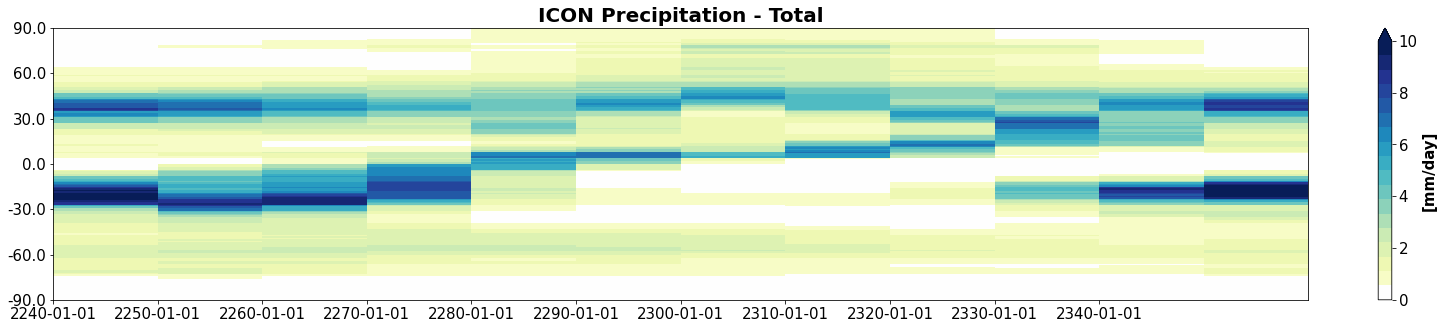

In [52]:
fig,ax = plt.subplots(figsize=(25,5))
im = ax.pcolormesh(x_icon,y_icon, AMZ_ctl_zonal_data, vmin=0, vmax=10,cmap=Cmap_rain_new)

#colorbar
cb = fig.colorbar(im,extend='max',fraction=0.05, pad=0.05)
cb.set_label(label='[mm/day]', size=15, weight='bold')
cb.ax.tick_params(labelsize=15)

# axis ticks
ax.set_xticks(x_axis[:])
ax.set_yticks(y_icon[::30])
ax.set_xticklabels(time_idx[:], fontsize=15)
ax.set_yticklabels(lat_idx[::3], fontsize=15)

ax.set_title("ICON Precipitation - Total", fontsize=20, weight='bold')
#ax.hlines(y=300, xmin=0, xmax=346, color='black',linewidth=1.5)

Text(0.5, 1.0, 'ICON Precipitation - Total')

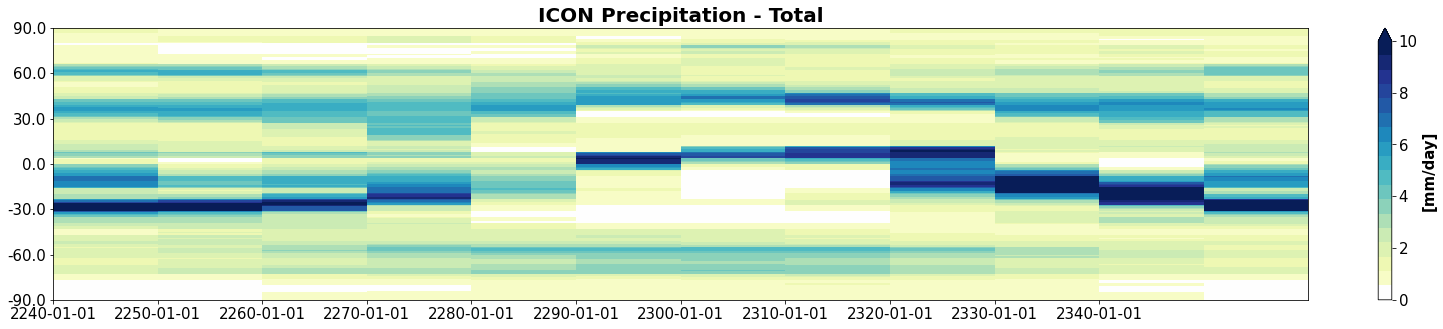

In [53]:
fig,ax = plt.subplots(figsize=(25,5))
im = ax.pcolormesh(x_icon,y_icon, AMZ_ens_zonal_data, vmin=0, vmax=10,cmap=Cmap_rain_new)

#colorbar
cb = fig.colorbar(im,extend='max',fraction=0.05, pad=0.05)
cb.set_label(label='[mm/day]', size=15, weight='bold')
cb.ax.tick_params(labelsize=15)

# axis ticks
ax.set_xticks(x_axis[:])
ax.set_yticks(y_icon[::30])
ax.set_xticklabels(time_idx[:], fontsize=15)
ax.set_yticklabels(lat_idx[::3], fontsize=15)

ax.set_title("ICON Precipitation - Total", fontsize=20, weight='bold')
#ax.hlines(y=300, xmin=0, xmax=346, color='black',linewidth=1.5)

Text(0.5, 1.0, 'ICON Precipitation - Total')

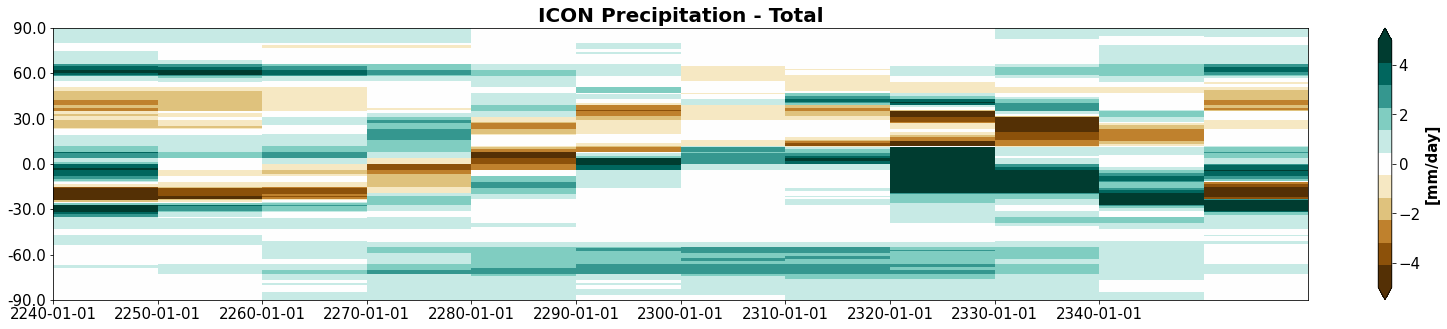

In [54]:
fig,ax = plt.subplots(figsize=(25,5))
im = ax.pcolormesh(x_icon,y_icon, AMZ_ens_zonal_data-AMZ_ctl_zonal_data, 
vmin=-5, vmax=5,cmap=BrBG_new)

#colorbar
cb = fig.colorbar(im,extend='both',fraction=0.05, pad=0.05)
cb.set_label(label='[mm/day]', size=15, weight='bold')
cb.ax.tick_params(labelsize=15)

# axis ticks
ax.set_xticks(x_axis[:])
ax.set_yticks(y_icon[::30])
ax.set_xticklabels(time_idx[:], fontsize=15)
ax.set_yticklabels(lat_idx[::3], fontsize=15)

ax.set_title("ICON Precipitation - Total", fontsize=20, weight='bold')
#ax.hlines(y=300, xmin=0, xmax=346, color='black',linewidth=1.5)

Text(0.5, 1.0, 'ICON Precipitation - Total')

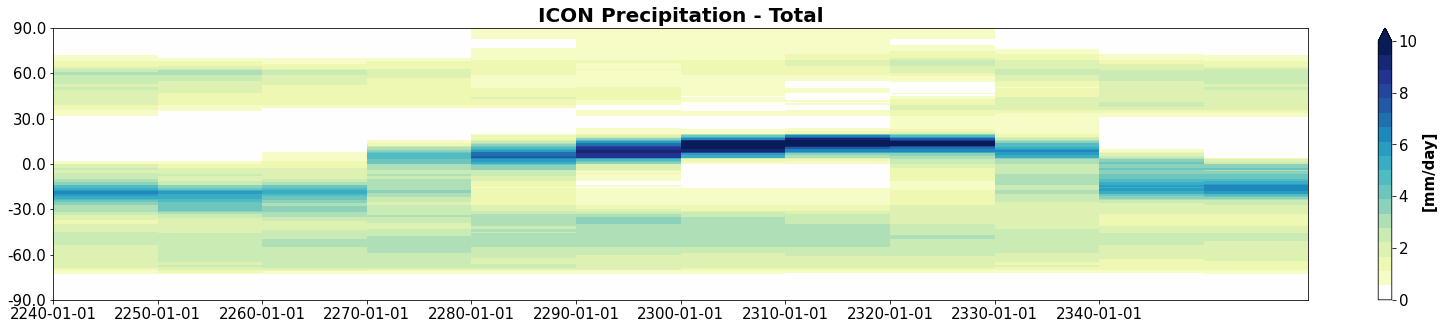

In [29]:
fig,ax = plt.subplots(figsize=(25,5))
im = ax.pcolormesh(x_icon,y_icon, AFC_ctl_zonal_data, vmin=0, vmax=10,cmap=Cmap_rain_new)

#colorbar
cb = fig.colorbar(im,extend='max',fraction=0.05, pad=0.05)
cb.set_label(label='[mm/day]', size=15, weight='bold')
cb.ax.tick_params(labelsize=15)

# axis ticks
ax.set_xticks(x_axis[:])
ax.set_yticks(y_icon[::30])
ax.set_xticklabels(time_idx[:], fontsize=15)
ax.set_yticklabels(lat_idx[::3], fontsize=15)

ax.set_title("ICON Precipitation - Total", fontsize=20, weight='bold')
#ax.hlines(y=300, xmin=0, xmax=346, color='black',linewidth=1.5)

Text(0.5, 1.0, 'ICON Precipitation - Total')

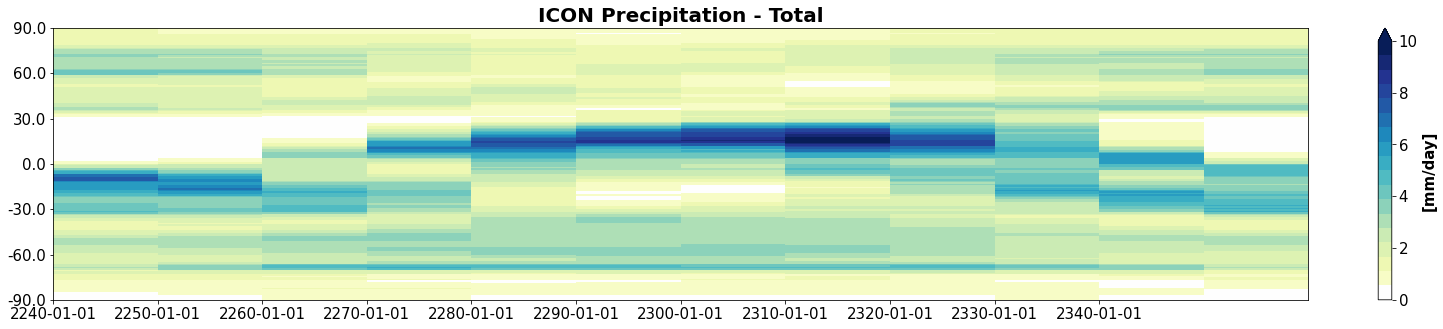

In [30]:
fig,ax = plt.subplots(figsize=(25,5))
im = ax.pcolormesh(x_icon,y_icon, AFC_ens_zonal_data, vmin=0, vmax=10,cmap=Cmap_rain_new)

#colorbar
cb = fig.colorbar(im,extend='max',fraction=0.05, pad=0.05)
cb.set_label(label='[mm/day]', size=15, weight='bold')
cb.ax.tick_params(labelsize=15)

# axis ticks
ax.set_xticks(x_axis[:])
ax.set_yticks(y_icon[::30])
ax.set_xticklabels(time_idx[:], fontsize=15)
ax.set_yticklabels(lat_idx[::3], fontsize=15)

ax.set_title("ICON Precipitation - Total", fontsize=20, weight='bold')
#ax.hlines(y=300, xmin=0, xmax=346, color='black',linewidth=1.5)

Text(0.5, 1.0, 'ICON Precipitation - Total')

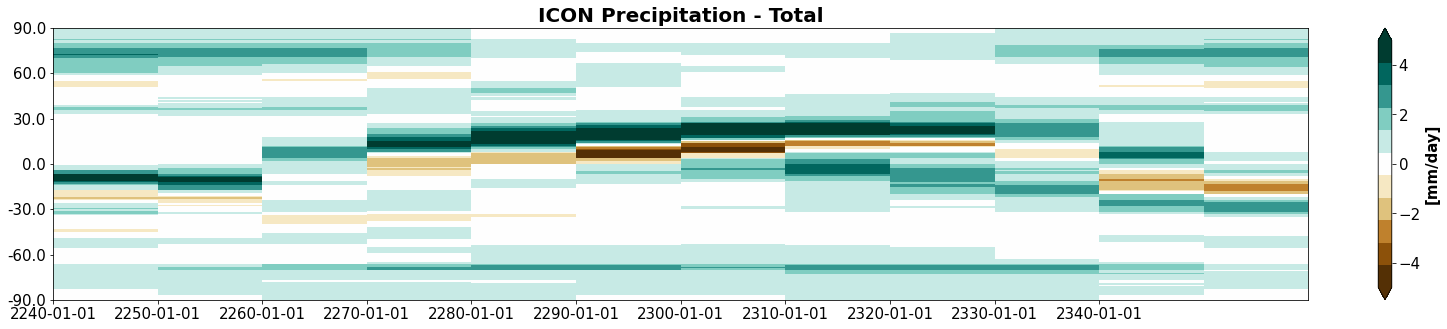

In [31]:
fig,ax = plt.subplots(figsize=(25,5))
im = ax.pcolormesh(x_icon,y_icon, AFC_ens_zonal_data-AFC_ctl_zonal_data, 
vmin=-5, vmax=5,cmap=BrBG_new)

#colorbar
cb = fig.colorbar(im,extend='both',fraction=0.05, pad=0.05)
cb.set_label(label='[mm/day]', size=15, weight='bold')
cb.ax.tick_params(labelsize=15)

# axis ticks
ax.set_xticks(x_axis[:])
ax.set_yticks(y_icon[::30])
ax.set_xticklabels(time_idx[:], fontsize=15)
ax.set_yticklabels(lat_idx[::3], fontsize=15)

ax.set_title("ICON Precipitation - Total", fontsize=20, weight='bold')
#ax.hlines(y=300, xmin=0, xmax=346, color='black',linewidth=1.5)

Text(0.5, 1.0, 'ICON Precipitation - Total')

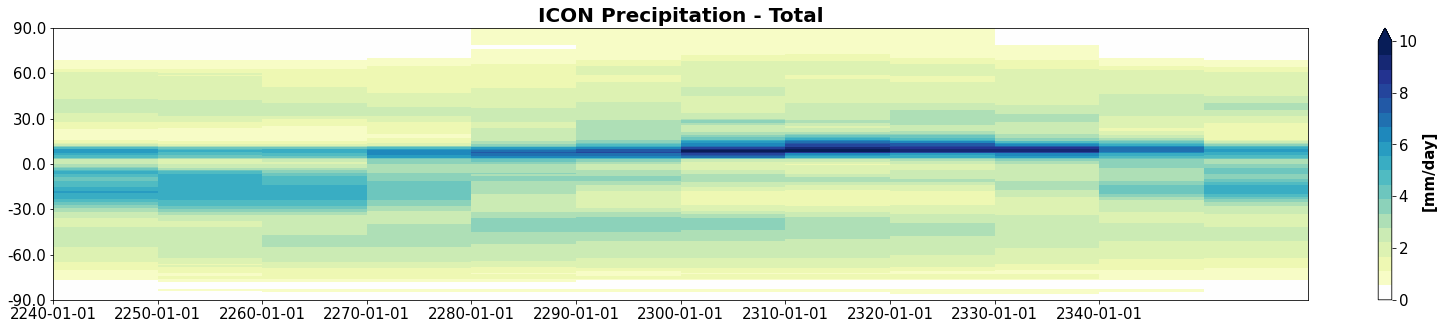

In [32]:
fig,ax = plt.subplots(figsize=(25,5))
im = ax.pcolormesh(x_icon,y_icon, TRP_ctl_zonal_data, vmin=0, vmax=10,cmap=Cmap_rain_new)

#colorbar
cb = fig.colorbar(im,extend='max',fraction=0.05, pad=0.05)
cb.set_label(label='[mm/day]', size=15, weight='bold')
cb.ax.tick_params(labelsize=15)

# axis ticks
ax.set_xticks(x_axis[:])
ax.set_yticks(y_icon[::30])
ax.set_xticklabels(time_idx[:], fontsize=15)
ax.set_yticklabels(lat_idx[::3], fontsize=15)

ax.set_title("ICON Precipitation - Total", fontsize=20, weight='bold')
#ax.hlines(y=300, xmin=0, xmax=346, color='black',linewidth=1.5)

Text(0.5, 1.0, 'ICON Precipitation - Total')

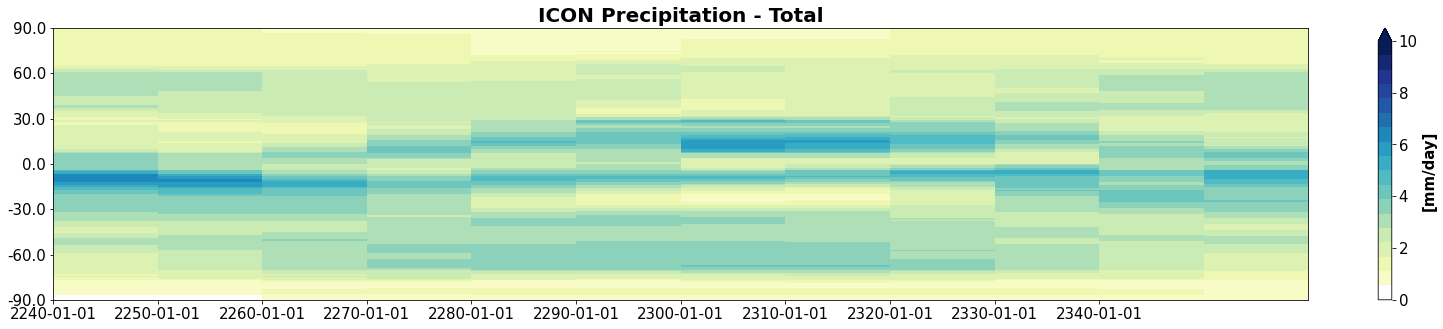

In [33]:
fig,ax = plt.subplots(figsize=(25,5))
im = ax.pcolormesh(x_icon,y_icon, TRP_ens_zonal_data, vmin=0, vmax=10,cmap=Cmap_rain_new)

#colorbar
cb = fig.colorbar(im,extend='max',fraction=0.05, pad=0.05)
cb.set_label(label='[mm/day]', size=15, weight='bold')
cb.ax.tick_params(labelsize=15)

# axis ticks
ax.set_xticks(x_axis[:])
ax.set_yticks(y_icon[::30])
ax.set_xticklabels(time_idx[:], fontsize=15)
ax.set_yticklabels(lat_idx[::3], fontsize=15)

ax.set_title("ICON Precipitation - Total", fontsize=20, weight='bold')
#ax.hlines(y=300, xmin=0, xmax=346, color='black',linewidth=1.5)

Text(0.5, 1.0, 'ICON Precipitation - Total')

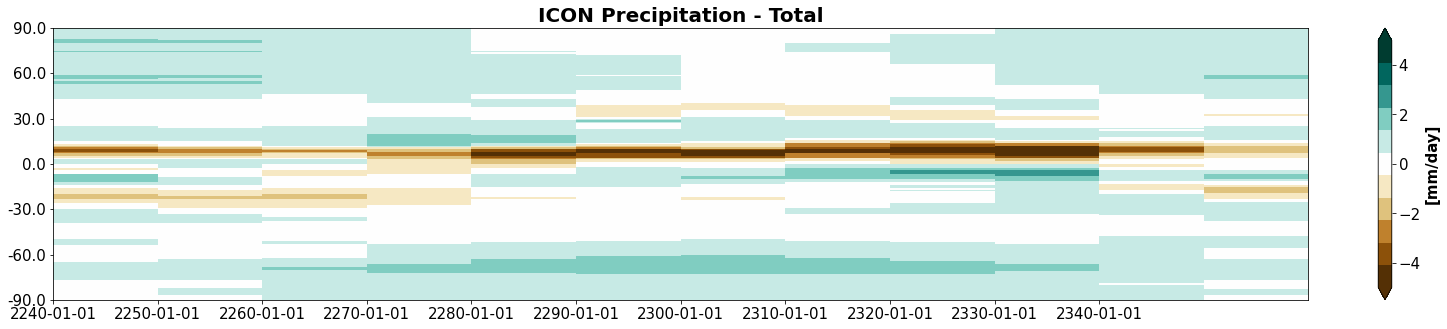

In [34]:
fig,ax = plt.subplots(figsize=(25,5))
im = ax.pcolormesh(x_icon,y_icon, TRP_ens_zonal_data-TRP_ctl_zonal_data, 
vmin=-5, vmax=5,cmap=BrBG_new)

#colorbar
cb = fig.colorbar(im,extend='both',fraction=0.05, pad=0.05)
cb.set_label(label='[mm/day]', size=15, weight='bold')
cb.ax.tick_params(labelsize=15)

# axis ticks
ax.set_xticks(x_axis[:])
ax.set_yticks(y_icon[::30])
ax.set_xticklabels(time_idx[:], fontsize=15)
ax.set_yticklabels(lat_idx[::3], fontsize=15)

ax.set_title("ICON Precipitation - Total", fontsize=20, weight='bold')
#ax.hlines(y=300, xmin=0, xmax=346, color='black',linewidth=1.5)

# latitude precipitation

(array([200., 220., 240., 260., 280., 300., 320.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

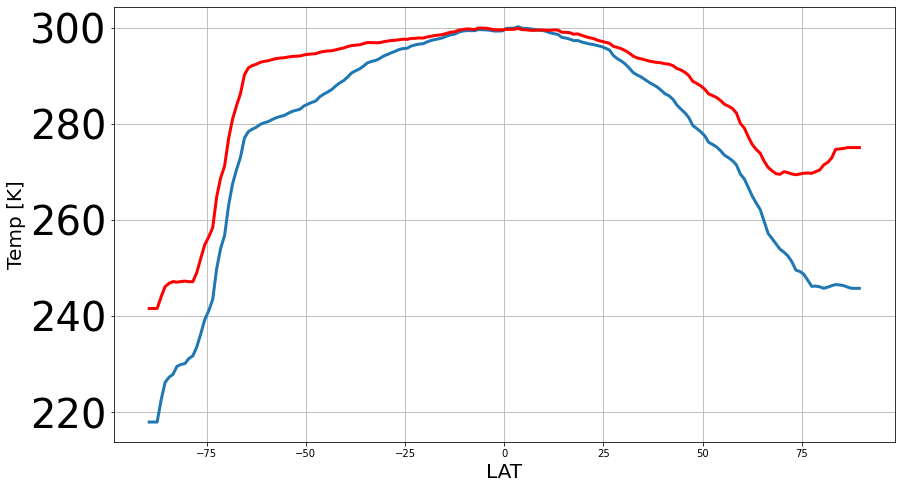

In [371]:
import datetime
fig = plt.figure(figsize=(14,8))
#fig.suptitle('Temperature for the last 100 years', size=20)

ctl_pres_zonal.plot.line(label="CTL", linewidth=3)
ens_pres_zonal.plot.line(label="ENS",c='red', linewidth=3)
#TRP_ens_zonal_mon.sel(time='2020-01-31T00:00:00.000000000').plot.line(label="ICON",linewidth=2, ls='--',c='black')

#era5_amz_spaiavg.plot.line(label="ERA5_AMZ")
#imerge_spaiavg_data.plot.line(label="IMERGE")
plt.ylabel('Temp [K]',fontsize=20)
plt.xlabel('LAT',fontsize=20)
plt.grid()
#plt.ylim(295,302)
#plt.xticks(fontsize=20)
plt.yticks(fontsize=40)
#plt.legend(fontsize=20)

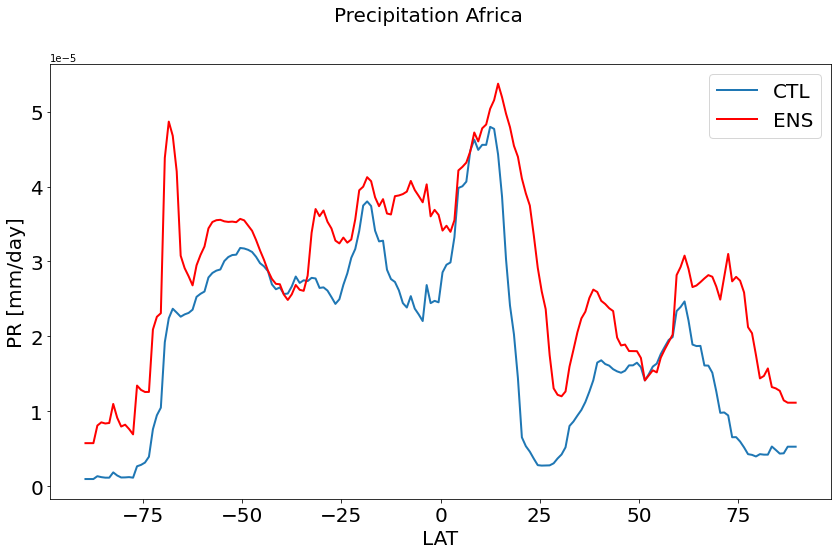

In [69]:
import datetime
fig = plt.figure(figsize=(14,8))
fig.suptitle('Precipitation Africa', size=20)

AFC_ctl_zonal_mon.plot.line(label="CTL", linewidth=2)
AFC_ens_zonal_mon.plot.line(label="ENS",c='red', linewidth=2)
#TRP_ens_zonal_mon.sel(time='2020-01-31T00:00:00.000000000').plot.line(label="ICON",linewidth=2, ls='--',c='black')

#era5_amz_spaiavg.plot.line(label="ERA5_AMZ")
#imerge_spaiavg_data.plot.line(label="IMERGE")
plt.ylabel('PR [mm/day]',fontsize=20)
plt.xlabel('LAT',fontsize=20)
#plt.ylim(295,302)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

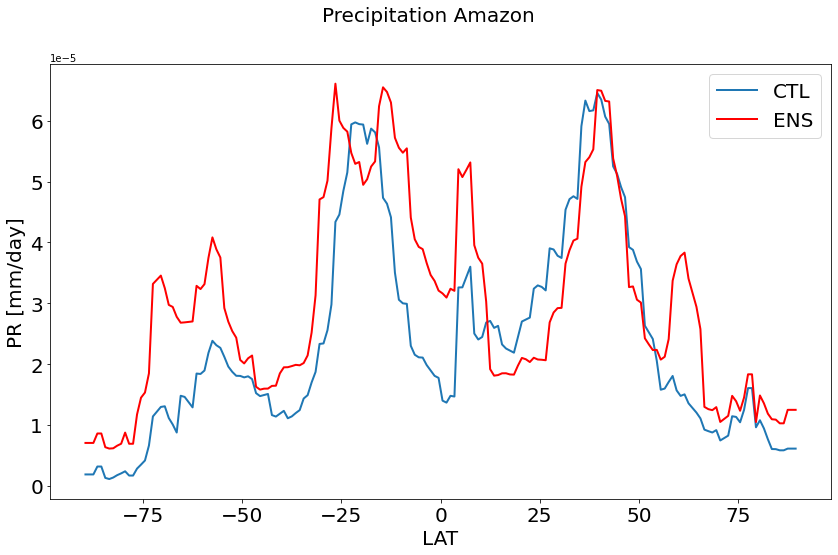

In [70]:
import datetime
fig = plt.figure(figsize=(14,8))
fig.suptitle('Precipitation Amazon', size=20)

AMZ_ctl_zonal_mon.plot.line(label="CTL", linewidth=2)
AMZ_ens_zonal_mon.plot.line(label="ENS",c='red', linewidth=2)
#TRP_ens_zonal_mon.sel(time='2020-01-31T00:00:00.000000000').plot.line(label="ICON",linewidth=2, ls='--',c='black')

#era5_amz_spaiavg.plot.line(label="ERA5_AMZ")
#imerge_spaiavg_data.plot.line(label="IMERGE")
plt.ylabel('PR [mm/day]',fontsize=20)
plt.xlabel('LAT',fontsize=20)
#plt.ylim(295,302)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

# 2D PLOT

In [327]:
ens_timavg.values.max()

0.20134186229370243

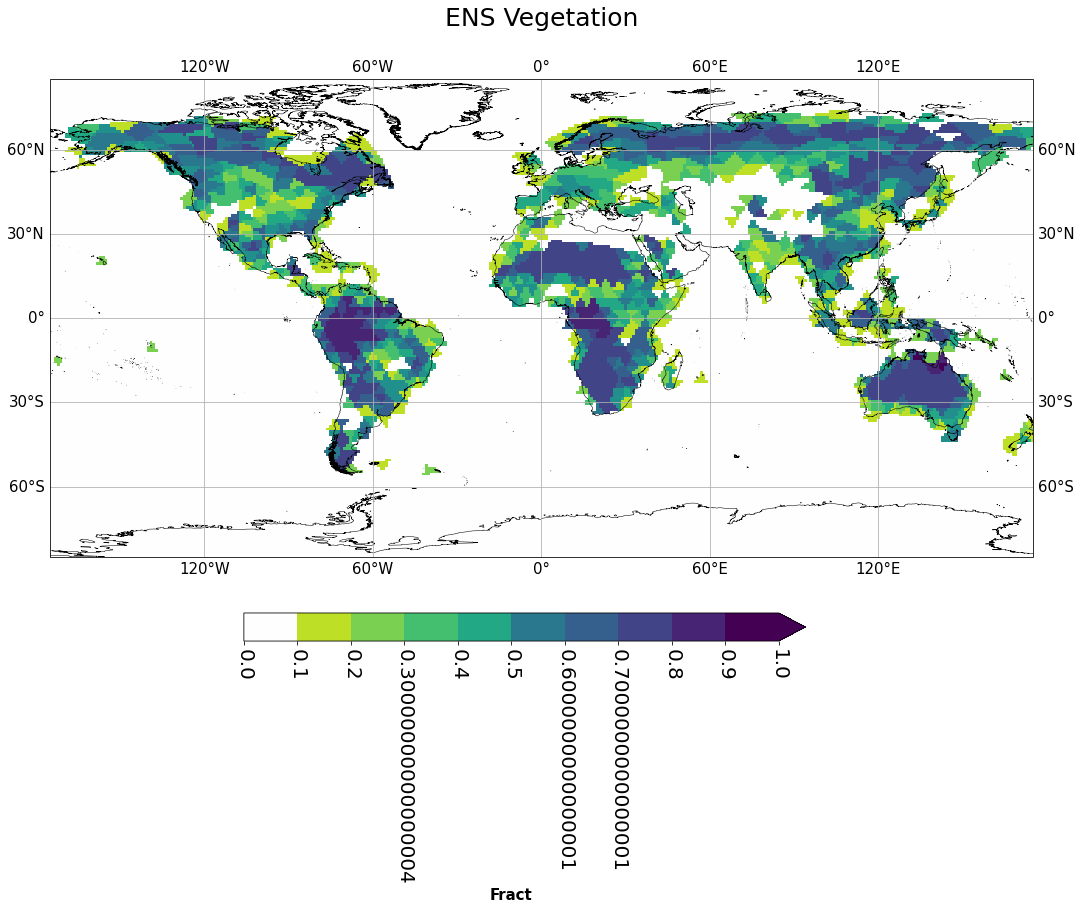

In [343]:
# title, data, label, colormap, varmin, varmax, space, lat_min, lat_max, lon_min, lon_max
contf_tmean(f'ENS Vegetation',ens_timavg,'Fract',Cmap_veg_new,'max', 
0, 1, 11,-90,90,-180,180)

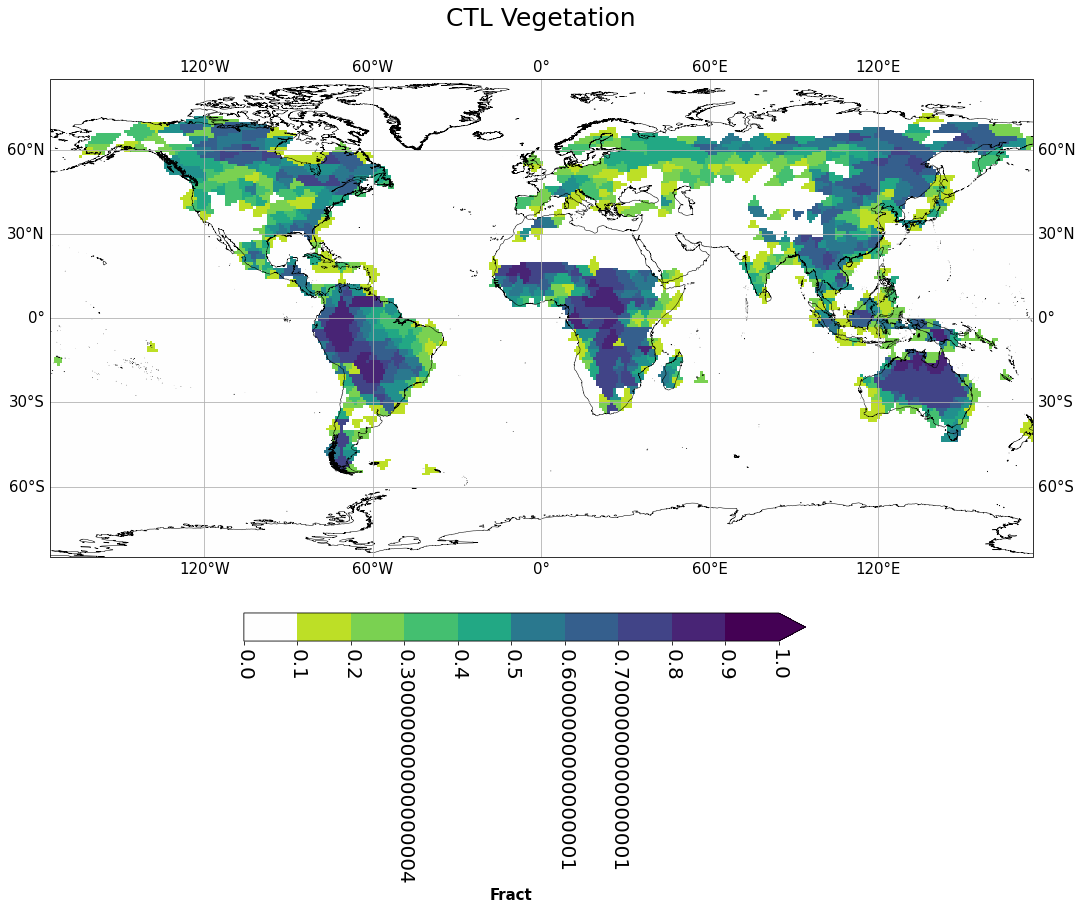

In [344]:
# title, data, label, colormap, varmin, varmax, space, lat_min, lat_max, lon_min, lon_max
contf_tmean(f'CTL Vegetation',ctl_timavg,'Fract',Cmap_veg_new,'max', 
0, 1, 11,-90,90,-180,180)

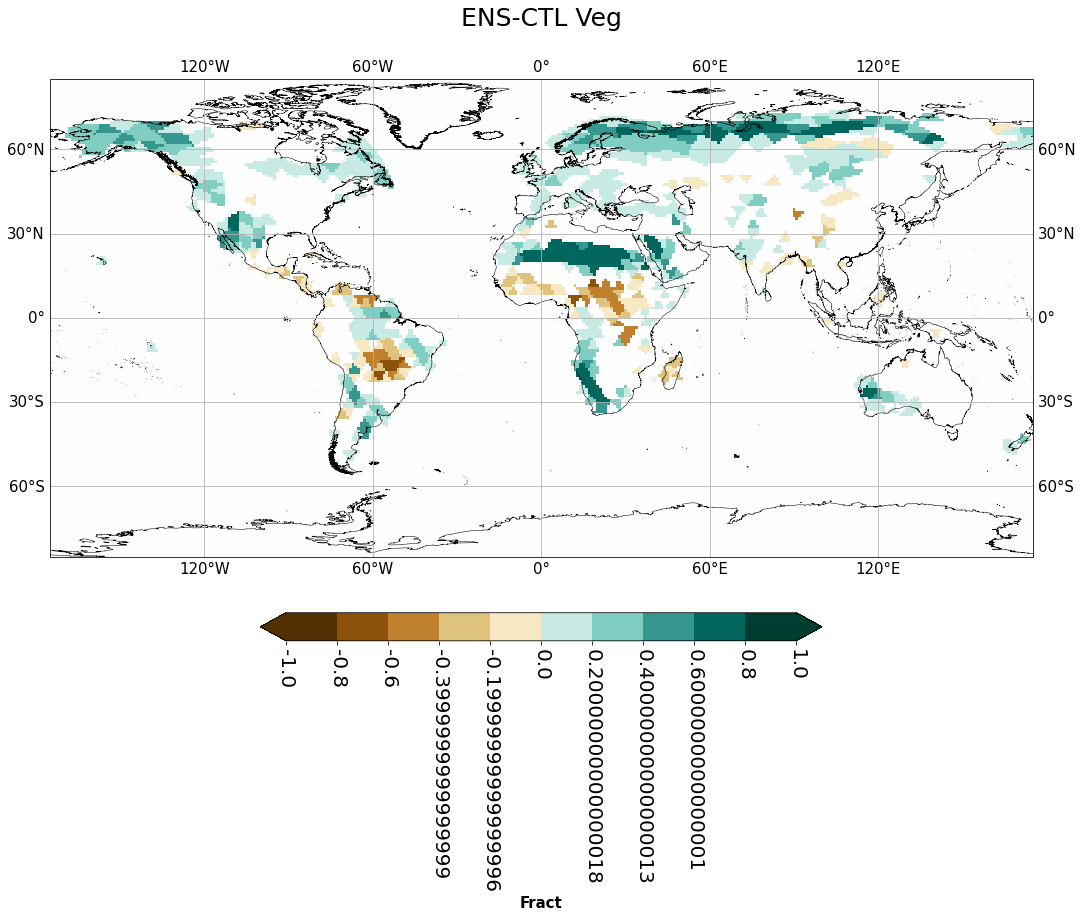

In [346]:
# title, data, label, colormap, varmin, varmax, space, lat_min, lat_max, lon_min, lon_max
contf_tmean(f'ENS-CTL Veg',ens_timavg-ctl_timavg,'Fract',BrBG_new,'both', 
-1, 1, 11,-90,90,-180,180)

# zonally mean of pressure / height, lat

In [136]:
ens_pres_zonal

<xarray.DataArray 'pfull' (height: 47, lat: 180)>
dask.array<mean_agg-aggregate, shape=(47, 180), dtype=float32, chunksize=(47, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * height   (height) float64 1.0 2.0 3.0 4.0 5.0 ... 43.0 44.0 45.0 46.0 47.0

In [141]:
# over the both land and ocean
ens_pres_zonal_data = ens_pres_zonal.values
ctl_pres_zonal_data = ctl_pres_zonal.values
print(np.shape(ctl_pres_zonal_data)) # x, y

x_pres = range(181) # 11 years * 12 months
y_pres = range(48)

(47, 180)


In [172]:
# over the both land and ocean
ens_pres_merid_data = ens_pres_merid.values
ctl_pres_merid_data = ctl_pres_merid.values
print(np.shape(ctl_pres_merid_data)) # x, y

x_pres = range(361) # 11 years * 12 months
y_pres = range(48)

(47, 360)


In [174]:
height_idx = np.arange(0,49,1)
lat_idx = np.arange(-90,91,10)
lon_idx = np.arange(-180,181,30)

Text(0.5, 1.0, 'ICON Pressure - Total')

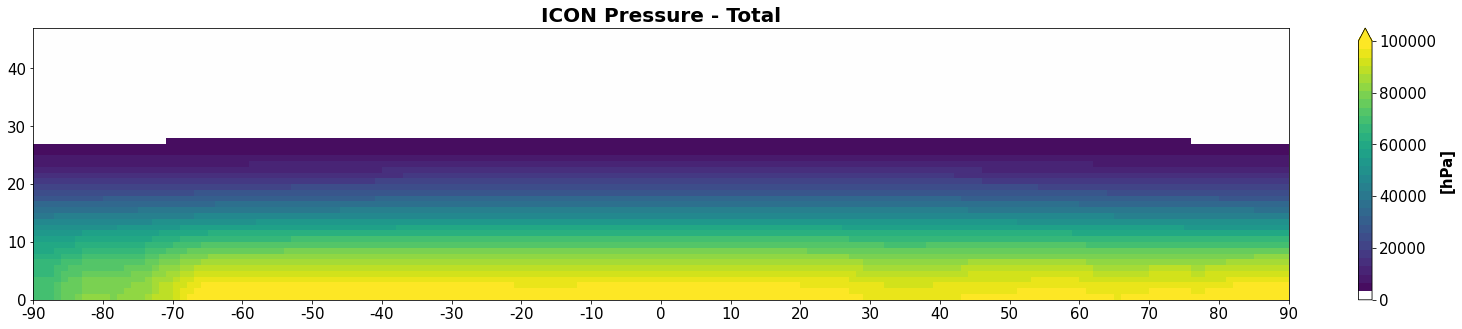

In [160]:
fig,ax = plt.subplots(figsize=(25,5))
im = ax.pcolormesh(x_pres,y_pres, ens_pres_zonal_data[::-1,:], 
vmin=0, vmax=100000,cmap=Cmap_pres_new)

#colorbar
cb = fig.colorbar(im,extend='max',fraction=0.05, pad=0.05)
cb.set_label(label='[hPa]', size=15, weight='bold')
cb.ax.tick_params(labelsize=15)

# axis ticks
ax.set_xticks(x_pres[::10])
ax.set_yticks(y_pres[::10])
ax.set_xticklabels(lat_idx[:], fontsize=15)
ax.set_yticklabels(height_idx[::10], fontsize=15)

ax.set_title("ICON Pressure - Total", fontsize=20, weight='bold')
#ax.hlines(y=300, xmin=0, xmax=346, color='black',linewidth=1.5)

Text(0.5, 1.0, 'ICON Pressure - Total')

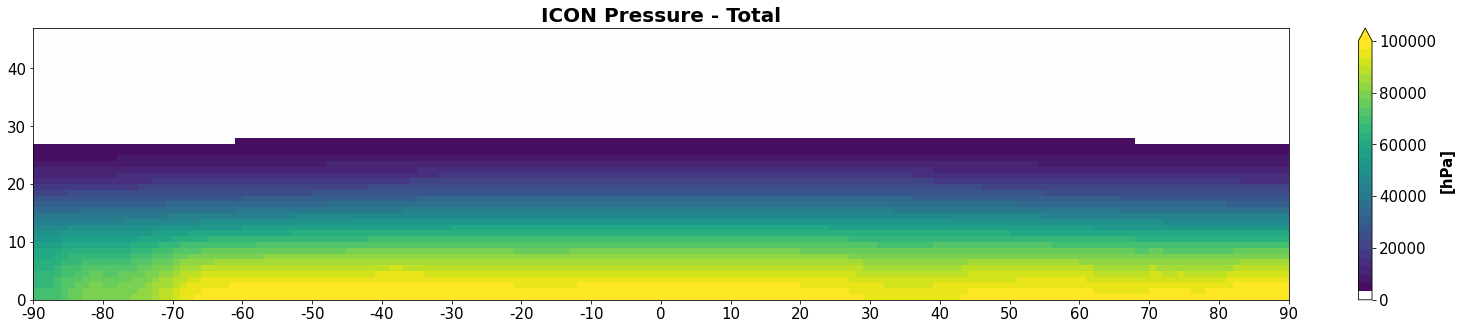

In [161]:
fig,ax = plt.subplots(figsize=(25,5))
im = ax.pcolormesh(x_pres,y_pres, ctl_pres_zonal_data[::-1,:], 
vmin=0, vmax=100000,cmap=Cmap_pres_new)

#colorbar
cb = fig.colorbar(im,extend='max',fraction=0.05, pad=0.05)
cb.set_label(label='[hPa]', size=15, weight='bold')
cb.ax.tick_params(labelsize=15)

# axis ticks
ax.set_xticks(x_pres[::10])
ax.set_yticks(y_pres[::10])
ax.set_xticklabels(lat_idx[:], fontsize=15)
ax.set_yticklabels(height_idx[::10], fontsize=15)

ax.set_title("ICON Pressure - Total", fontsize=20, weight='bold')
#ax.hlines(y=300, xmin=0, xmax=346, color='black',linewidth=1.5)

Text(0.5, 1.0, 'ENS-CTL Press')

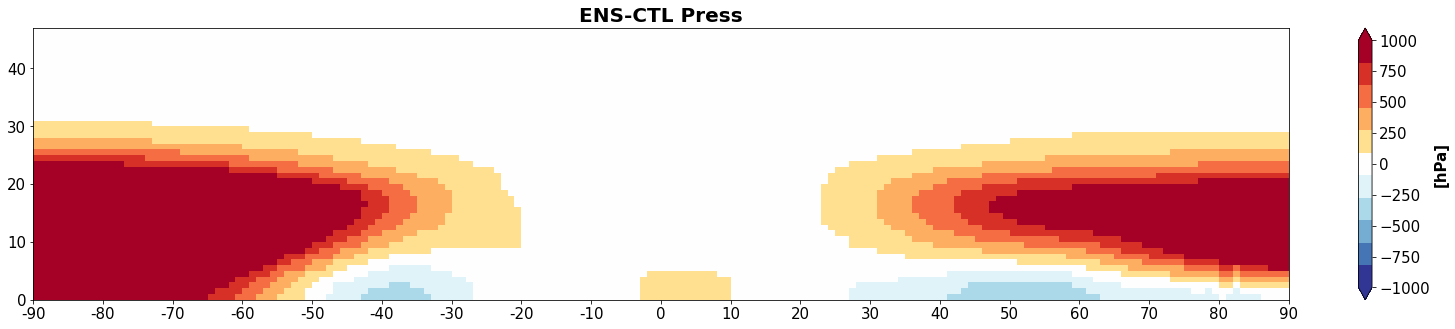

In [170]:
fig,ax = plt.subplots(figsize=(25,5))
im = ax.pcolormesh(x_pres,y_pres, ens_pres_zonal_data[::-1,:]-ctl_pres_zonal_data[::-1,:], 
vmin=-1000, vmax=1000,cmap=pres_diff_new)

#colorbar
cb = fig.colorbar(im,extend='both',fraction=0.05, pad=0.05)
cb.set_label(label='[hPa]', size=15, weight='bold')
cb.ax.tick_params(labelsize=15)

# axis ticks
ax.set_xticks(x_pres[::10])
ax.set_yticks(y_pres[::10])
ax.set_xticklabels(lat_idx[:], fontsize=15)
ax.set_yticklabels(height_idx[::10], fontsize=15)

ax.set_title("ENS-CTL Press", fontsize=20, weight='bold')
#ax.hlines(y=300, xmin=0, xmax=346, color='black',linewidth=1.5)

Text(0.5, 1.0, 'ENS-CTL Press')

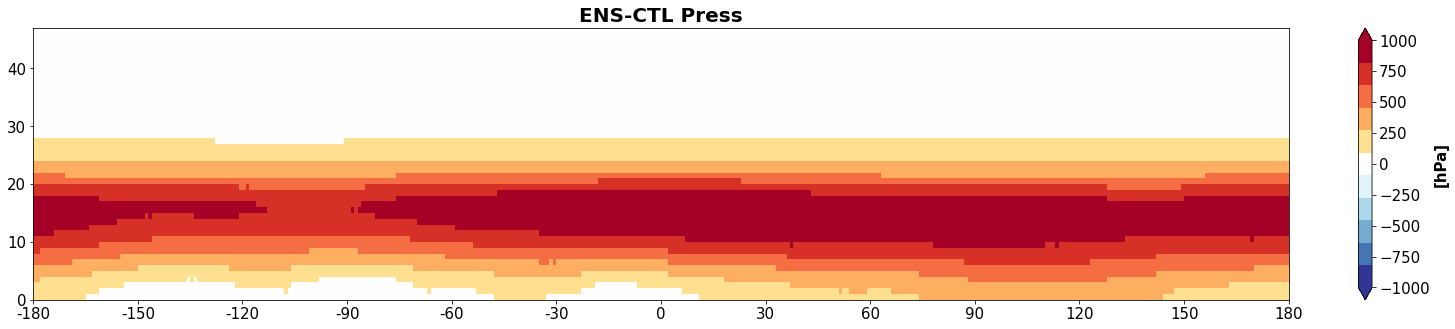

In [176]:
fig,ax = plt.subplots(figsize=(25,5))
im = ax.pcolormesh(x_pres,y_pres, ens_pres_merid_data[::-1,:]-ctl_pres_merid_data[::-1,:], 
vmin=-1000, vmax=1000,cmap=pres_diff_new)

#colorbar
cb = fig.colorbar(im,extend='both',fraction=0.05, pad=0.05)
cb.set_label(label='[hPa]', size=15, weight='bold')
cb.ax.tick_params(labelsize=15)

# axis ticks
ax.set_xticks(x_pres[::30])
ax.set_yticks(y_pres[::10])
ax.set_xticklabels(lon_idx[:], fontsize=15)
ax.set_yticklabels(height_idx[::10], fontsize=15)

ax.set_title("ENS-CTL Press", fontsize=20, weight='bold')
#ax.hlines(y=300, xmin=0, xmax=346, color='black',linewidth=1.5)

In [5]:
path_grid =Path('/work/mh1049/k206184/icon-easyms/experiments/sus22M3/outdata/sus22M3_lnd_basic_ml_19800101.nc')
dset_grid = xr.open_dataset(path_grid)
cellpoints = np.rad2deg(np.stack([dset_grid.clon.values, dset_grid.clat.values], axis=-1))
cellpoints.min()

-178.99998

In [6]:
print(np.shape(dset_grid.clon.values))
print(np.shape(dset_grid.clat.values))

(5120,)
(5120,)


In [29]:
import numpy as np
from scipy.interpolate import NearestNDInterpolator

lon = np.deg2rad(np.linspace(-180, 180, 600))
lat = np.deg2rad(np.linspace(-90, 90, 300))
lon2, lat2 = np.meshgrid(lon, lat)

points_icon = np.vstack((dset_grid.clon, dset_grid.clat)).T
data_sample = dset_atm[:].sel(time="2240-01-31", method="nearest")

nn_interpolation = NearestNDInterpolator(points_icon, data_sample.values)
interpolated_nn = nn_interpolation((lon2, lat2))

In [20]:
data_sample

<xarray.DataArray 'pr' (ncells: 5120)>
dask.array<getitem, shape=(5120,), dtype=float32, chunksize=(5120,), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 1850-12-31T23:45:00
Dimensions without coordinates: ncells
Attributes:
    standard_name:                pr
    long_name:                    precipitation flux
    units:                        kg m-2 s-1
    param:                        52.1.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [44]:
def colormap_create(cmap, cnumber, loc_boundary_low, loc_boundary_high):
    get_cmap = cm.get_cmap(cmap,cnumber) 
    cmap_edit = get_cmap(np.linspace(0,1,cnumber))
    white = np.array([255/256, 255/256, 255/256, 1])
    cmap_edit[loc_boundary_low:loc_boundary_high] = white
    cmap_new = matplotlib.colors.ListedColormap(cmap_edit)
    return cmap_new

In [106]:
Cmap_temp_new = colormap_create('RdYlBu_r',31,0,1)
Cmap_rain_new = colormap_create('YlGnBu',18,0,1)
BrBG_new = colormap_create('BrBG',11,5,6)

In [69]:
def contf_diff(title, data, colormap, varmin, varmax, space):
    lats = dset_grid.clat
    lons = dset_grid.clon

    fig = plt.figure(figsize=[18,12],facecolor='w')
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_extent([-175+180,175+180,-30,30])
    ax.coastlines('50m',linewidth=0.8)
    grid_lines = ax.gridlines(draw_labels=True)
    grid_lines.xformatter = LONGITUDE_FORMATTER
    grid_lines.yformatter = LATITUDE_FORMATTER

    m = ax.pcolormesh(lons,lats,data,cmap=colormap,vmin=varmin,vmax=varmax,transform=ccrs.PlateCarree())
    cbar = plt.colorbar(m,fraction=0.01, pad=0.04,extend='both')
    cbar_ticks = np.linspace(varmin, varmax, num=space)
    cbar.set_ticks(cbar_ticks)
    cbar.ax.tick_params(labelsize=18)

    ax.set_title(title,y=1.1,fontsize=20,fontweight='bold')
    plt.show()

In [26]:
interpolated_nn.max()

0.00032937407

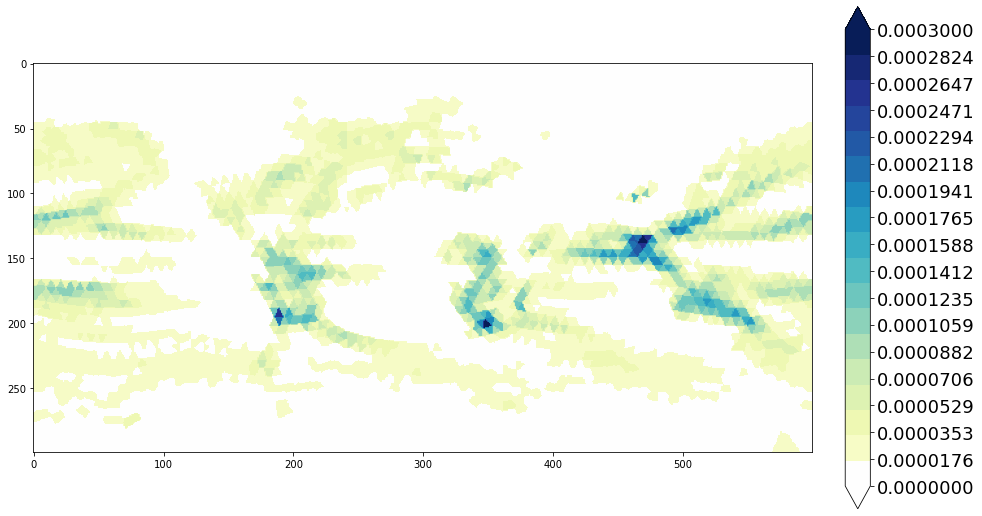

In [27]:
import matplotlib.pylab as plt

plt.figure(figsize=(15,15))
m=plt.imshow(np.flipud(interpolated_nn),cmap=Cmap_rain_new,vmin=0,vmax=0.0003)
cbar = plt.colorbar(m,fraction=0.03, pad=0.04,extend='both')
cbar_ticks = np.linspace(0, 0.0003, num=18)
cbar.set_ticks(cbar_ticks)
cbar.ax.tick_params(labelsize=18)

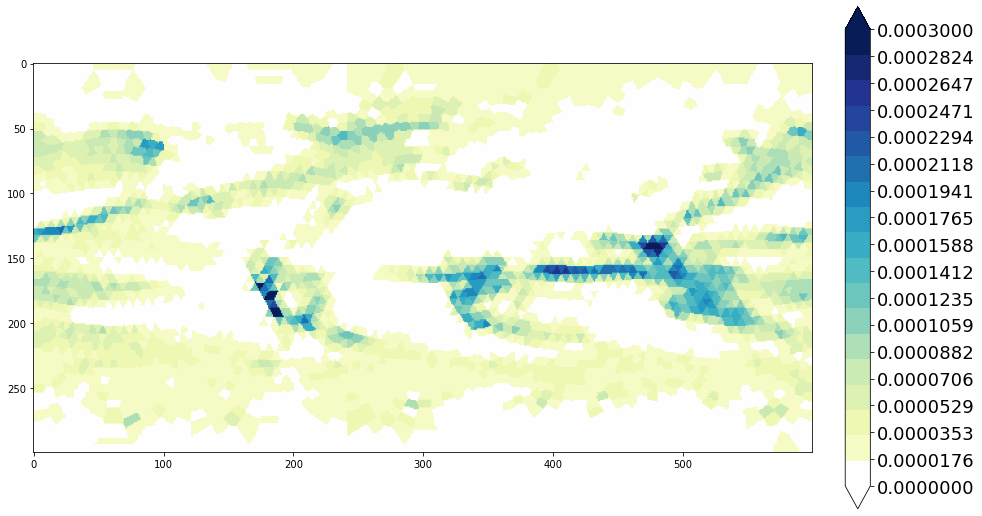

In [33]:
import matplotlib.pylab as plt

plt.figure(figsize=(15,15))
m=plt.imshow(np.flipud(interpolated_nn),cmap=Cmap_rain_new,vmin=0,vmax=0.0003)
cbar = plt.colorbar(m,fraction=0.03, pad=0.04,extend='both')
cbar_ticks = np.linspace(0, 0.0003, num=18)
cbar.set_ticks(cbar_ticks)
cbar.ax.tick_params(labelsize=18)